# Ryder: Global Expansion Research #
<a id="top" />

This Jupyter notebook contains the summaries and visualizations that should accompany the report on Ryder's company expansion into other countries, based on key indicators derived from a country's level of crime and stability, basic measures of health and wealth, and ratios of public education spending.

***

## Table of Contents ##

1. [Title](#top)
2. [Introduction](#introduction)
3. [Dependencies](#dependencies)
4. [Prepare for Analysis](#prepare)<br/>
    a. [Import Countries](#import_countries)<br/>
    b. [Selecting Countries](#select_countries)<br/>
    c. [Import Data](#import_data)<br/>
        i. [Import MFI](#import_data_mfi)<br/>
        ii. [Import GTD](#import_data_gtd)<br/>
        iii. [Import PED](#import_data_ped)<br/>
5. [Queries](#query)<br/>
    a. [Query MFI](#query_mfi)<br/>
    b. [Query GTD](#query_gtd)<br/>
    c. [Query PED](#query_ped)<br/>

***

<a id="introduction" />

## Introduction ##

This notebook contains queries made against cleansed versions of the following Kaggle datasets:

- [Global Terrorism Database](https://www.kaggle.com/START-UMD/gtd) (2018)
- [Infant Mortality, Fertility, Income per Capita](https://www.kaggle.com/burhanykiyakoglu/infant-mortality-fertility-income) (2018)
- [Public Education Expenditure as share of GDP](https://www.kaggle.com/ibrahimmukherjee/gdp-world-bank-data#public-education-expenditure-as-share-of-gdp.csv) (2018)

Datasets were prepared using a combination of different commandline tools, including `bash`, `awk`, `sed`, and `python`. The original wide datasets were broken up to better facilitate querying. Details on that process are included in the accompanying documentation.

***

<a id="dependencies" />

## Dependencies ##

This notebook requires the following packages:

    - numpy
    - pandas 
    - matplotlib

Before we can plot information and fiddle with the data, we need to import these modules.


In [1]:
import numpy as np         # numpy library for vectorized computations.
import pandas as pd        # pandas library for manipulating dataframes.

### pandas & numpy ###

Pandas allows us to manipulate dataframes.

We can create these dataframes by reading in our data. `*.tsv` files can be imported using the `read_csv()` function. Note the custom `\t` separator used with tab-separated-value files.

```python
# Outputs a dataframe from a parsed data file.
dataframe = pd.read_csv("<filename>.tsv", sep="\t")
```

### matplotlib ###

We can also import matplotlib and the pylot modules for configuration and later use.

In [2]:
import matplotlib as mpl   # matplotlib library for global settings.
import matplotlib.pyplot as plt  # Our plotting functions from matplotlib.

In [3]:
display(plt.style.available)  # Display what styles are available.

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

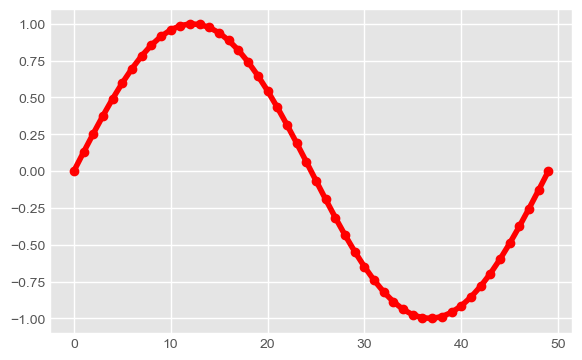

In [4]:
# %matplotlib inline
%config InlineBackend.figure_format = 'png'
                                     # Above lines makes plots appear as inline svgs.
mpl.rcParams['figure.dpi'] = 100     # Apply DPI to matplotlib inline plots.
plt.style.use(['fivethirtyeight', 'seaborn-dark', 'ggplot'])     # Apply particular styles.
plt.plot(np.sin(np.linspace(0, 2 * np.pi)), 'r-o')  # Make the plot.
plt.show()  # Show the plot.

***

<a id="prepare"></a>

## Preparing for Analysis ##

The following packages contain support functions unique to this particular report.

The `analysis.analyser` package contains the `analyser` and `country` modules that do a bulk of the computational work. The `analysis.utils` package contains utility modules used to do repetitive tasks across the entire project.

In [5]:
from analysis.analyser import analyser
from analysis.analyser.country import Country
from analysis.utils import parser
from analysis.utils import validate

<a id="import_countries" />

#### Selecting Candidate Countries ####

We need to select countries from our dataset's available countries. This means finding the above three (3) countries and ensuring they have entries across all three datasets.

In [6]:
# Outputs a dataframe from a parsed data file.
countries_df = parser.read_tsv("../data/country_codes.tsv")
display(countries_df)

,ID,Code,Country
0,4,AFG,Afghanistan
1,5,ALB,Albania
2,6,DZA,Algeria
3,7,AND,Andorra
4,8,AGO,Angola
...,...,...,...
156,603,GBR,United Kingdom
157,1001,SRB,Serbia
158,1002,MNE,Montenegro
159,1003,XKX,Kosovo


In [7]:
# Get the np.array of unique countries that appear in the public education expenditure dataset.
ped_countries_df = parser.read_tsv("../data/ped/ped_countries.tsv")
keys_ped = Country.from_frame(countries_df, search=list(ped_countries_df.iloc[:,0].unique()))
print(Country.format(keys_ped, sep="\n"))

Found 17 result(s) for search terms: AUS, AUT, BEL, CAN, CHE, DEU, ESP, FRA, GBR, IRL, ITA, JPN, NLD, NOR, NZL, SWE, USA
<[AUS 14]: "Australia">
<[AUT 15]: "Austria">
<[BEL 21]: "Belgium">
<[CAN 38]: "Canada">
<[CHE 199]: "Switzerland">
<[DEU 75]: "Germany">
<[ESP 185]: "Spain">
<[FRA 69]: "France">
<[GBR 603]: "United Kingdom">
<[IRL 96]: "Ireland">
<[ITA 98]: "Italy">
<[JPN 101]: "Japan">
<[NLD 142]: "Netherlands">
<[NOR 151]: "Norway">
<[NZL 144]: "New Zealand">
<[SWE 198]: "Sweden">
<[USA 217]: "United States">


In [8]:
# Get np.array of unique countries that appear in the infant mortality, fertility, income per capita dataset.
mfi_countries_df = parser.read_tsv("../data/mfi/mfi_countries.tsv")
keys_mfi = Country.from_frame(countries_df, search=mfi_countries_df.iloc[:,0].unique())
print(Country.format(keys_mfi[:5], sep="\n"), "\n...\n", Country.format(keys_mfi[-5:], sep="\n"))

Found 161 result(s) for search terms: ABW, AFG, AGO, ALB, AND, ARE, ARG, ARM, ASM, ATG, AUS, AUT, AZE, BDI, BEL, BEN, BFA, BGD, BGR, BHR, BHS, BIH, BLR, BLZ, BMU, BOL, BRA, BRB, BRN, BTN, BWA, CAF, CAN, CHE, CHI, CHL, CHN, CIV, CMR, COD, COG, COL, COM, CPV, CRI, CUB, CUW, CYM, CYP, CZE, DEU, DJI, DMA, DNK, DOM, DZA, ECU, EGY, ERI, ESP, EST, ETH, FIN, FJI, FRA, FRO, FSM, GAB, GBR, GEO, GHA, GIB, GIN, GMB, GNB, GNQ, GRC, GRD, GRL, GTM, GUM, GUY, HKG, HND, HRV, HTI, HUN, IDN, IMN, IND, IRL, IRN, IRQ, ISL, ISR, ITA, JAM, JOR, JPN, KAZ, KEN, KGZ, KHM, KIR, KNA, KOR, KWT, LAO, LBN, LBR, LBY, LCA, LIE, LKA, LSO, LTU, LUX, LVA, MAC, MAF, MAR, MCO, MDA, MDG, MDV, MEX, MHL, MKD, MLI, MLT, MMR, MNE, MNG, MNP, MOZ, MRT, MUS, MWI, MYS, NAM, NCL, NER, NGA, NIC, NLD, NOR, NPL, NRU, NZL, OMN, PAK, PAN, PER, PHL, PLW, PNG, POL, PRI, PRK, PRT, PRY, PSE, PYF, QAT, ROU, RUS, RWA, SAU, SDN, SEN, SGP, SLB, SLE, SLV, SMR, SOM, SRB, SSD, STP, SUR, SVK, SVN, SWE, SWZ, SXM, SYC, SYR, TCA, TCD, TGO, THA, TJK, TK

In [9]:
# Get np.array of unique countries that appear in the global terrorism database.
gtd_countries_df = parser.read_tsv("../data/gtd/gtd_countries.tsv")
keys_gtd = Country.from_frame(countries_df, search=gtd_countries_df.iloc[:,0].unique())
print(Country.format(keys_gtd[:5], sep="\n"), "\n...\n", Country.format(keys_gtd[-5:], sep="\n"))

Found 161 result(s) for search terms: 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 127, 128, 129, 130, 132, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 149, 151, 153, 155, 156, 157, 158, 159, 160, 161, 162, 164, 166, 167, 168, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 189, 190, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 226, 228, 229, 230, 231, 235, 236, 347, 349, 359, 362, 377, 403, 406, 422, 428, 499, 532, 603, 604, 605, 1001, 1002, 1003, 1004
<[AFG 4]: "Afghanistan">

In [10]:
# Compute the unique available countries among the datasets.
country_codes = {
    "ped": list(map(lambda country: country.code, keys_ped)),
    "mfi": list(map(lambda country: country.code, keys_mfi)),
    "gtd": list(map(lambda country: country.code, keys_gtd))
}

# Find the available countries.
unique_codes = analyser.find_intersection(*country_codes.values())
print(f'Unique Codes: {unique_codes}')

available_countries = countries_df[countries_df["Code"].isin(unique_codes)]
display(available_countries)

Unique Codes: ['FRA', 'ITA', 'USA', 'NOR', 'BEL', 'CHE', 'DEU', 'AUS', 'GBR', 'IRL', 'SWE', 'JPN', 'NZL', 'AUT', 'ESP', 'NLD', 'CAN']


,ID,Code,Country
8,14,AUS,Australia
9,15,AUT,Austria
14,21,BEL,Belgium
27,38,CAN,Canada
51,69,FRA,France
55,75,DEU,Germany
70,96,IRL,Ireland
72,98,ITA,Italy
74,101,JPN,Japan
101,142,NLD,Netherlands


In [11]:
# Clear unused variables in IPython.
%reset_selective -f "^id$"
%reset_selective -f "^code$"
%reset_selective -f "^name$"

# Equivalent: del keys_ped
# Equivalent: del keys_mfi
# Equivalent: del keys_gtd
%reset_selective -f "_ped$"
%reset_selective -f "_mfi$"
%reset_selective -f "_gtd$"

# Equivalent: del ped_countries_df
# Equivalent: del mfi_countries_df
# Equivalent: del gtd_countries_df
%reset_selective -f "_countries_df$"

# Equivalent: del country_codes
# Equivalent: del unique_codes
%reset_selective -f "_codes$"

<a id="select_countries" />

#### Selecting Countries ####

Now, with a sense of what countries are available, we can select 3 countries (besides the current one, USA) for comparison.

In [12]:
# The countries we want to evaluate.
codes = [
    "GBR",  # United Kingdom,
    "JPN",  # Japan,
    "SWE",  # Sweden,
    "USA"   # United States
    ]
display(codes)

['GBR', 'JPN', 'SWE', 'USA']

In [13]:
# Select these countries from the set of available countries.
selected_df = available_countries[available_countries["Code"].isin(codes)]
selected_df = selected_df.set_index("Code", drop=False)
display(selected_df)

,ID,Code,Country
Code,,,
JPN,101,JPN,Japan
SWE,198,SWE,Sweden
USA,217,USA,United States
GBR,603,GBR,United Kingdom


In [14]:
# Convert selected countries into Country representations for use across all datasets.
selected_countries = Country.get_countries(selected_df)
print(Country.format(selected_countries, sep="\n"))

<[JPN 101]: "Japan">
<[SWE 198]: "Sweden">
<[USA 217]: "United States">
<[GBR 603]: "United Kingdom">


<a id="import_data" />

### Importing Data ###

In order to query the data, we need to form our `pandas.DataFrame` representations.

<a id="import_data_mfi" />

#### Mortality ####

The mortality, fertility, and income datasets were made tidy, so that important can be done in a relatively consistent manner. The important feature for the infant mortality dataset is the 'Mortality Rate'.

In [15]:
# Get the mortality table using the parser.read_mfi helper function.
mortality_df = parser.read_mfi(
    '../data/mfi/mortality/mortality_long.tsv', 
    title="Mortality Rate",
    countries=selected_df.index)    
display(mortality_df)

,original_index,Code,Country,Year,Mortality Rate
0,45,GBR,United Kingdom,1970,18.0
1,184,GBR,United Kingdom,1971,17.7
2,327,GBR,United Kingdom,1972,17.1
3,473,GBR,United Kingdom,1973,16.6
4,620,GBR,United Kingdom,1974,16.0
...,...,...,...,...,...
183,7790,USA,United States,2012,6.0
184,7983,USA,United States,2013,5.9
185,8176,USA,United States,2014,5.8
186,8369,USA,United States,2015,5.7


In [16]:
# Get the fertility table using the parser.read_mfi helper function.
fertility_df = parser.read_mfi(
    '../data/mfi/fertility/fertility_long.tsv', 
    title="Fertility Rate",
    countries=selected_df.index)    
display(fertility_df)

,original_index,Code,Country,Year,Fertility Rate
0,62,GBR,United Kingdom,1970,2.4
1,253,GBR,United Kingdom,1971,2.4
2,446,GBR,United Kingdom,1972,2.2
3,638,GBR,United Kingdom,1973,2.0
4,829,GBR,United Kingdom,1974,1.9
...,...,...,...,...,...
183,8434,USA,United States,2012,1.9
184,8634,USA,United States,2013,1.9
185,8834,USA,United States,2014,1.9
186,9035,USA,United States,2015,1.8


In [17]:
# Get the income table using the parser.read_mfi helper function.
income_df = parser.read_mfi(
    '../data/mfi/income/income_long.tsv', 
    title="Income",
    countries=selected_df.index)    
display(income_df)

,original_index,Code,Country,Year,Income
0,21,GBR,United Kingdom,1970,2220.021490
1,79,GBR,United Kingdom,1971,2484.150369
2,158,GBR,United Kingdom,1972,2823.686879
3,238,GBR,United Kingdom,1973,3192.310330
4,318,GBR,United Kingdom,1974,3393.134062
...,...,...,...,...,...
183,5729,USA,United States,2012,44582.333450
184,5900,USA,United States,2013,45548.288240
185,6069,USA,United States,2014,47344.285540
186,6239,USA,United States,2015,49058.089400


<a id="import_data_gtd" />

#### Import Terrorism Database ####

In [18]:
# Import the terrorism database.
crime_df = parser.read_tsv('../data/gtd/gtd.tsv')

# Rename columns.
crime_df.columns = ['Event ID', 'Country ID', 'Country', 'Year', 'Success', 'Attack Type ID', 'Attack Type', 'Killed', 'Wounded']

In [19]:
# Import the terrorism database.
crime_df = parser.read_tsv('../data/gtd/gtd.tsv')

# Rename columns.
crime_df.columns = ['Event ID', 'Country ID', 'Country', 'Year', 'Success', 'Attack Type ID', 'Attack Type', 'Killed', 'Wounded']

In [20]:
# Descriptive statistics regarding the entire dataset.
print("Results for the overall dataset:")
display(crime_df.describe(include=np.object))
display(crime_df.drop(labels=['Event ID', 'Country ID'], axis=1).describe())

Results for the overall dataset:


,Country,Attack Type
count,181691,181691
unique,205,9
top,Iraq,Bombing/Explosion
freq,24636,88255


,Year,Success,Attack Type ID,Killed,Wounded
count,181691.000000,181691.000000,181691.000000,171378.000000,165380.000000
mean,2002.638997,0.889598,3.247547,2.403272,3.167668
std,13.259430,0.313391,1.915772,11.545741,35.949392
min,1970.000000,0.000000,1.000000,0.000000,0.000000
25%,1991.000000,1.000000,2.000000,0.000000,0.000000
50%,2009.000000,1.000000,3.000000,0.000000,0.000000
75%,2014.000000,1.000000,3.000000,2.000000,2.000000
max,2017.000000,1.000000,9.000000,1570.000000,8191.000000


In [21]:
# Preparing for queries.
print("Selecting for candidate countries...")
crime_df = crime_df[crime_df['Country ID'].isin(selected_df['ID'])]

print("Mapping country ID to country code...")
id_map = dict(selected_df[['ID', 'Code']].values)
crime_df['Code'] = crime_df['Country ID'].map(id_map)

print("Summing to get casualty total...")
crime_df['Casualties'] = crime_df['Killed'] + crime_df['Wounded']

print("Reorganize columns...")
crime_df = crime_df[['Event ID', 'Code', 'Country', 'Year', 'Attack Type', 'Killed', 'Wounded', 'Casualties', 'Success']]

Selecting for candidate countries...
Mapping country ID to country code...
Summing to get casualty total...
Reorganize columns...


In [22]:
display(crime_df)

,Event ID,Code,Country,Year,Attack Type,Killed,Wounded,Casualties,Success
4,197001000003,JPN,Japan,1970,Facility/Infrastructure Attack,NaN,NaN,NaN,1
5,197001010002,USA,United States,1970,Armed Assault,0.0,0.0,0.0,1
7,197001020002,USA,United States,1970,Bombing/Explosion,0.0,0.0,0.0,1
8,197001020003,USA,United States,1970,Facility/Infrastructure Attack,0.0,0.0,0.0,1
9,197001030001,USA,United States,1970,Facility/Infrastructure Attack,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
181488,201712230009,GBR,United Kingdom,2017,Armed Assault,0.0,1.0,1.0,1
181530,201712250016,SWE,Sweden,2017,Bombing/Explosion,0.0,0.0,0.0,1
181535,201712250021,GBR,United Kingdom,2017,Facility/Infrastructure Attack,0.0,0.0,0.0,0
181556,201712260017,GBR,United Kingdom,2017,Armed Assault,0.0,1.0,1.0,1


<a id="import_data_ped" />

#### Import Public Expenditure Data ####

In [23]:
# Import the public expenditure database.
ped_df = parser.read_tsv('../data/ped/ped.tsv')
display(ped_df)

,Entity,Code,Year,Public Expenditure on Education (percent of GDP)
0,Australia,AUS,1937,0.7
1,Australia,AUS,1960,1.4
2,Australia,AUS,1980,5.5
3,Australia,AUS,1993,6.0
4,Austria,AUT,1937,2.5
...,...,...,...,...
69,United Kingdom,GBR,1960,4.3
70,United Kingdom,GBR,1980,5.6
71,United Kingdom,GBR,1993,5.4
72,United States,USA,1960,4.0


In [24]:
print("Rename columns...")
ped_df = ped_df.rename(columns={ 'Entity': 'Country', 'Public Expenditure on Education (percent of GDP)': "%GDP" })

print("Reorder columns...")
ped_df = ped_df[['Code', 'Country', 'Year', '%GDP']]

print("Selecting countries...")
ped_df = ped_df[ped_df['Code'].isin(selected_df['Code'])]

print("Sorting by year...")
ped_df = ped_df.sort_values(by=["Code", "Year"], axis=0)
display(ped_df)

Rename columns...
Reorder columns...
Selecting countries...
Sorting by year...


,Code,Country,Year,%GDP
66,GBR,United Kingdom,1870,0.1
67,GBR,United Kingdom,1913,1.1
68,GBR,United Kingdom,1937,4.0
69,GBR,United Kingdom,1960,4.3
70,GBR,United Kingdom,1980,5.6
71,GBR,United Kingdom,1993,5.4
35,JPN,Japan,1870,1.0
36,JPN,Japan,1913,1.6
37,JPN,Japan,1937,2.1
38,JPN,Japan,1960,4.1


In [25]:
# Descriptions for selected countries.
display(ped_df.describe(include=np.object))
display(ped_df.describe())
display(ped_df.groupby(['Code']).describe().drop(labels="Year", axis=1))

,Code,Country
count,17,17
unique,4,4
top,JPN,United Kingdom
freq,6,6


,Year,%GDP
count,17.000000,17.000000
mean,1952.470588,4.223529
std,40.518696,2.466153
min,1870.000000,0.100000
25%,1937.000000,2.100000
50%,1960.000000,4.300000
75%,1980.000000,5.500000
max,1993.000000,9.000000


%GDP                                                  
     count      mean       std  min    25%   50%    75%  max
Code                                                        
GBR    6.0  3.416667  2.288595  0.1  1.825  4.15  5.125  5.6
JPN    6.0  3.216667  1.919809  1.0  1.725  3.10  4.550  5.8
SWE    3.0  7.500000  2.100000  5.1  6.750  8.40  8.700  9.0
USA    2.0  4.750000  1.060660  4.0  4.375  4.75  5.125  5.5

***

<a id="query" />

## Queries ##

The objective of the research project is to evaluate key indicators of stability and growth across several countries in order to estimate Ryder's potential for success in these new markets.

This sample report evaluates the trends in three (3) separate countries as a sampling of what the broader international research has to offer. **The United Kingdom** (GBR), **Japan** (JPN), and **Sweden** (SWE).

The **United States of America** (USA) is included in order to use our current operation region for context.

For each of these countries, we want to answer the following questions:

    1. Is infant mortality improving, stable, or getting worse?
    2. Is income rising, stagnant, or falling?
    3. Does one country or another seem more or less stable than the others, and why do you say this?
    4. What changes do you predict for these countries, and why?

<a id="query_mfi" />

### Infant Mortality ###

For **each country** in `selected_countries`, observations regarding infant mortality per 1,000 live births can be determined with the following steps:

- Summraize rates of infant mortality per 1,000 live births per year, for each country.

- Plot a time-series showing infant mortality trends in each country.

In [26]:
# Query 1a. Average infant mortality per 1,000 live births per year, by country.
# print(describe_numeric(mortality_df.groupby(['Code']), 'Mortality Rate'))
mortality_stats_year = mortality_df.groupby(['Code']).agg({
    'Year': [
        'count',
        'min',
        'max',
        analyser.spread(),
        analyser.percentile(0),
        analyser.percentile(0.25),
        analyser.percentile(0.5),
        analyser.percentile(0.75),
        analyser.percentile(1),
        analyser.IQR()
    ]
}).dropna(axis=1,how='all')
print(mortality_stats_year)

mortality_stats_rate = mortality_df.groupby(['Code']).agg({
    'Mortality Rate': [
        'min',
        'idxmin',
        'max',
        'idxmax'
    ]
}).dropna(axis=1,how='all')
print(mortality_stats_rate)

mortality_quartiles = mortality_df.groupby(['Code']).agg({ 
    'Mortality Rate': [ 
        analyser.percentile(0), 
        analyser.percentile(0.25),
        analyser.percentile(0.5),
        analyser.percentile(0.75),
        analyser.percentile(1),
        analyser.IQR(),
        analyser.spread()
    ]
})
print(mortality_quartiles)

      Year                                                        
     count   min   max range    0%     25%   50%     75%  100% IQR
Code                                                              
GBR     47  1970  2016    46  1970  1981.5  1993  2004.5  2016  23
JPN     47  1970  2016    46  1970  1981.5  1993  2004.5  2016  23
SWE     47  1970  2016    46  1970  1981.5  1993  2004.5  2016  23
USA     47  1970  2016    46  1970  1981.5  1993  2004.5  2016  23
     Mortality Rate                    
                min idxmin   max idxmax
Code                                   
GBR             3.7     45  18.0      0
JPN             2.0     91  13.4     47
SWE             2.4    137  11.3     94
USA             5.6    187  19.9    141
     Mortality Rate                                    
                 0%   25%  50%    75%  100%   IQR range
Code                                                   
GBR             3.7  5.20  6.5  11.10  18.0  5.90  14.3
JPN             2.0  2.80  

Plotting Infant mortality rate, by country (1970 to 2016) for each 4 countr(y/ies) across 47 year(s)...


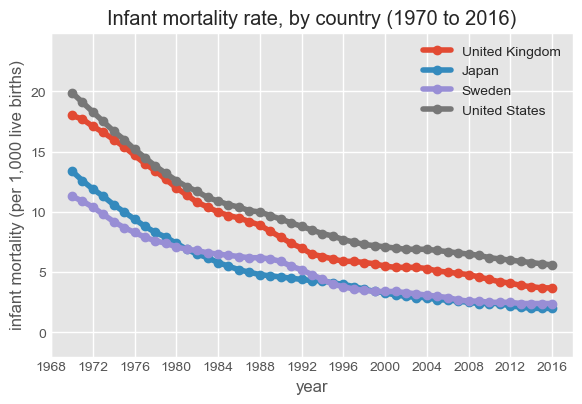

In [27]:
# Query 1b. Time-series plot showing infant mortality trends, by country.

df = mortality_df.drop(labels=['original_index'], axis=1)

num_years = df['Year'].nunique()
num_countries = df['Code'].nunique()
year_min = df['Year'].min()
year_max = df['Year'].max()

options = {
    'xlabel': 'year',
    'ylabel': 'infant mortality (per 1,000 live births)',
    'title': f'Infant mortality rate, by country ({year_min} to {year_max})',
    'xlim': (year_min - 2, year_max + 2),
    'ylim': (-2, df['Mortality Rate'].max() * 1.25),
}

# Plot the mortality information.
print(f'Plotting {options["title"]} for each {num_countries} countr(y/ies) across {num_years} year(s)...')
fig, ax = plt.subplots()

for key, grp in df.groupby(['Code']):
    ax.plot('Year', 'Mortality Rate', 'o-', data=grp, label=df[df['Code'] == key]['Country'].unique()[0])

ax.set(**options)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(15))

ax.legend(loc='upper right', frameon=False)
ax.grid(True)

### National Net Income per Capita ###

For **each country** in `selected_countries`, observations regarding NNI per Capita (in 2018 $USD) can be determined with the following steps:

- Summarize the NNI per Capita per year, for each country.

- Plot a time-series showing NNI per Capita trends in each country.

In [28]:
# Query 2a. Summarize the NNI per Capita per year, for each country.
income_stats = income_df.groupby(['Code']).agg({
    'Income': [
        'min',
        'idxmin',
        'max',
        'idxmax'
    ]
}).dropna(axis=1,how='all')
print(income_stats)

income_quartiles = income_df.groupby(['Code']).agg({ 
    'Income': [ 
        analyser.percentile(0), 
        analyser.percentile(0.25),
        analyser.percentile(0.5),
        analyser.percentile(0.75),
        analyser.percentile(1),
        analyser.IQR(),
        analyser.spread()
    ]
})
print(income_quartiles)


           Income                           
              min idxmin          max idxmax
Code                                        
GBR   2220.021490      0  43373.05583     37
JPN   1669.294920     47  38613.65124     89
SWE   4162.080806     94  51423.65653    137
USA   4591.218634    141  49725.78053    187
           Income                                                        \
               0%           25%          50%           75%         100%   
Code                                                                      
GBR   2220.021490   7383.203197  17406.97758  33321.134415  43373.05583   
JPN   1669.294920   8167.404551  25157.27898  30266.593825  38613.65124   
SWE   4162.080806  11549.905215  24782.95466  36537.575590  51423.65653   
USA   4591.218634  11739.246895  21977.62957  36657.289395  49725.78053   

                                  
               IQR         range  
Code                              
GBR   25937.931218  41153.034340  
JPN   22099.189274 

Plotting NNI per Capita, by country (1970 to 2016) in 2018 $USD for each 4 countr(y/ies) across 47 year(s)...


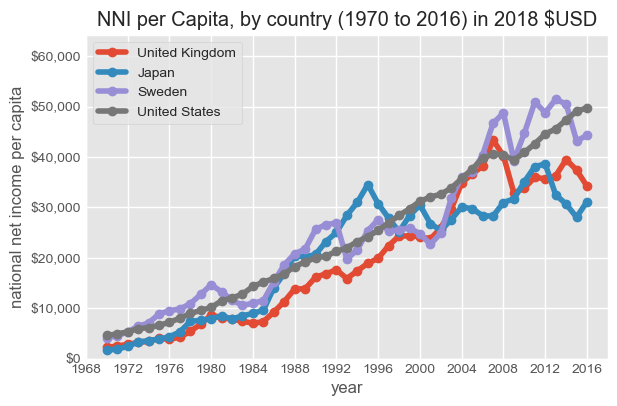

In [29]:
# Query 2b. Plot a time-series showing NNI per Capita trends in each country.
df = income_df.drop(labels=['original_index'], axis=1)

num_years = df['Year'].nunique()
num_countries = df['Code'].nunique()
year_min = df['Year'].min()
year_max = df['Year'].max()

options = {
    'xlabel': 'year',
    'ylabel': 'national net income per capita',
    'title': f'NNI per Capita, by country ({year_min} to {year_max}) in 2018 $USD',
    'xlim': (year_min - 2, year_max + 2),
    'ylim': (-2, df['Income'].max() * 1.25),
}

# Plot the mortality information.
print(f'Plotting {options["title"]} for each {num_countries} countr(y/ies) across {num_years} year(s)...')
fig, ax = plt.subplots()

for key, grp in df.groupby(['Code']):
    ax.plot('Year', 'Income', 'o-', data=grp, label=df[df['Code'] == key]['Country'].unique()[0])

ax.set(**options)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(15))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

ax.legend(loc='upper left', frameon=True)
ax.grid(True)

plt.show()

<a id="query_gtd" />

### Crime & Stability ###

For **each country** in `selected_countries`, observations regarding terrorist incidents can be determined with the following steps:

- Summarize the terrorism incidents per year, for each country.

- Plot a time-series showing crime and stability in each country.

In [30]:
# Query 3a. Summarize the terrorism incidents per year, for each country.
display(crime_df.groupby(['Code']).nunique()[['Event ID', 'Year', 'Attack Type']])

crime_stats = crime_df.groupby(['Code']).agg({
    'Killed': [
        'min',
        'idxmin',
        'max',
        'idxmax',
        'count',
        'sum',
    ],
    'Wounded': [
        'min',
        'idxmin',
        'max',
        'idxmax',
        'sum',
    ],   
    'Casualties': [
        'min',
        'idxmin',
        'max',
        'idxmax',
        'sum',
    ],   
    'Attack Type': [
        'count',
        'max',
        'nunique',
        analyser.mode(), 
    ], 
}).dropna(axis=1,how='all')
display(crime_stats)

crime_quartiles = crime_df.groupby(['Code']).agg({ 
    'Killed': [ 
        analyser.mode(), 
        analyser.percentile(0), 
        analyser.percentile(0.25),
        analyser.percentile(0.5),
        analyser.percentile(0.75),
        analyser.percentile(1),
        analyser.IQR(),
        analyser.spread()
    ],
    'Wounded': [ 
        analyser.mode(), 
        analyser.percentile(0), 
        analyser.percentile(0.25),
        analyser.percentile(0.5),
        analyser.percentile(0.75),
        analyser.percentile(1),
        analyser.IQR(),
        analyser.spread()
    ],
    'Casualties': [
        analyser.mode(), 
        analyser.percentile(0), 
        analyser.percentile(0.25),
        analyser.percentile(0.5),
        analyser.percentile(0.75),
        analyser.percentile(1),
        analyser.IQR(),
        analyser.spread()
    ],   
})
display(crime_quartiles)

,Event ID,Year,Attack Type
Code,,,
GBR,5235,47,9
JPN,402,36,9
SWE,132,28,8
USA,2836,47,9


Killed                                      Wounded                 \
        min idxmin     max  idxmax count     sum     min idxmin     max   
Code                                                                      
GBR     0.0    514   270.0   36669  5065  3410.0     0.0    514   340.0   
JPN     0.0    162    19.0  165205   373    66.0     0.0    162  5500.0   
SWE     0.0    709     5.0  173709   131    22.0     0.0    709    15.0   
USA     0.0      5  1384.0   73126  2763  3771.0     0.0      5  8191.0   

                      Casualties                                 Attack Type  \
      idxmax      sum        min idxmin     max  idxmax      sum       count   
Code                                                                           
GBR    78432   6106.0        0.0    514   367.0   78432   7591.0        5235   
JPN    58841   6998.0        0.0    162  5513.0   58841   7013.0         402   
SWE   172449     80.0        0.0    709    19.0  173709    101.0         132   
USA    73127  20702.0        0.0      5  9574.0   73126  24469.0        2836   

                                                       
          max nunique                            mode  
Code                                                   
GBR   Unknown       9               Bombing/Explosion  
JPN   Unknown       9  Facility/Infrastructure Attack  
SWE   Unknown       8  Facility/Infrastructure Attack  
USA   Unknown       9               Bombing/Explosion

Killed                                          Wounded       ...       \
       mode   0%  25%  50%  75%    100%  IQR   range    mode   0%  ...  IQR   
Code                                                               ...        
GBR     0.0  0.0  0.0  0.0  1.0   270.0  1.0   270.0     0.0  0.0  ...  1.0   
JPN     0.0  0.0  0.0  0.0  0.0    19.0  0.0    19.0     0.0  0.0  ...  0.0   
SWE     0.0  0.0  0.0  0.0  0.0     5.0  0.0     5.0     0.0  0.0  ...  0.0   
USA     0.0  0.0  0.0  0.0  0.0  1384.0  0.0  1384.0     0.0  0.0  ...  0.0   

             Casualties                                           
       range       mode   0%  25%  50%  75%    100%  IQR   range  
Code                                                              
GBR    340.0        0.0  0.0  0.0  0.0  1.0   367.0  1.0   367.0  
JPN   5500.0        0.0  0.0  0.0  0.0  0.0  5513.0  0.0  5513.0  
SWE     15.0        0.0  0.0  0.0  0.0  0.0    19.0  0.0    19.0  
USA   8191.0        0.0  0.0  0.0  0.0  0.0  9574.0  0.0  9574.0  

[4 rows x 24 columns]

In [31]:
crime_desc = crime_df.drop(labels=['Event ID'], axis=1).groupby(['Code', 'Attack Type']).describe()

print('Country Terrorist Attacks by Year')
display(crime_desc['Year'][['count', 'min', '50%', 'max']])

print('Country Terrorist Attack Casualties')
display(crime_desc[['Killed', 'Wounded']].drop(labels=['25%', '75%', 'mean', 'std'], axis=1, level=1))

print('Country Terrorist Attack Casualties')
display(crime_desc['Casualties'])


Country Terrorist Attacks by Year


count     min     50%     max
Code Attack Type                                                        
GBR  Armed Assault                         670.0  1970.0  1991.0  2017.0
     Assassination                        1651.0  1971.0  1979.0  2017.0
     Bombing/Explosion                    2092.0  1970.0  1989.0  2017.0
     Facility/Infrastructure Attack        652.0  1970.0  1994.0  2017.0
     Hijacking                              19.0  1973.0  2009.0  2017.0
     Hostage Taking (Barricade Incident)    14.0  1973.0  1986.5  2015.0
     Hostage Taking (Kidnapping)            53.0  1970.0  1981.0  2017.0
     Unarmed Assault                        46.0  1974.0  2000.5  2017.0
     Unknown                                38.0  1975.0  1983.5  2016.0
JPN  Armed Assault                          47.0  1978.0  1990.0  1996.0
     Assassination                          22.0  1978.0  1990.5  1995.0
     Bombing/Explosion                     128.0  1975.0  1990.0  2015.0
     Facility/Infrastructure Attack        162.0  1970.0  1990.0  2015.0
     Hijacking                               3.0  1970.0  1974.0  1995.0
     Hostage Taking (Barricade Incident)     3.0  1991.0  1994.0  2016.0
     Hostage Taking (Kidnapping)             1.0  1991.0  1991.0  1991.0
     Unarmed Assault                        29.0  1978.0  1995.0  2000.0
     Unknown                                 7.0  1979.0  1991.0  1995.0
SWE  Armed Assault                          17.0  1971.0  2015.0  2017.0
     Assassination                           7.0  1971.0  1991.0  1997.0
     Bombing/Explosion                      38.0  1972.0  1999.0  2017.0
     Facility/Infrastructure Attack         60.0  1978.0  2015.0  2017.0
     Hijacking                               2.0  1972.0  1994.5  2017.0
     Hostage Taking (Barricade Incident)     1.0  1975.0  1975.0  1975.0
     Unarmed Assault                         3.0  1990.0  2017.0  2017.0
     Unknown                                 4.0  1991.0  1991.5  1992.0
USA  Armed Assault                         284.0  1970.0  1981.0  2017.0
     Assassination                         133.0  1970.0  1979.0  2017.0
     Bombing/Explosion                    1383.0  1970.0  1976.0  2017.0
     Facility/Infrastructure Attack        864.0  1970.0  1989.0  2017.0
     Hijacking                              17.0  1970.0  1983.0  2013.0
     Hostage Taking (Barricade Incident)    62.0  1971.0  1983.0  2017.0
     Hostage Taking (Kidnapping)            21.0  1970.0  1980.0  2017.0
     Unarmed Assault                        61.0  1970.0  2000.0  2017.0
     Unknown                                11.0  1971.0  1982.0  1994.0

Country Terrorist Attack Casualties


Killed                   Wounded  \
                                           count  min  50%     max   count   
Code Attack Type                                                             
GBR  Armed Assault                         658.0  0.0  0.0    11.0   471.0   
     Assassination                        1650.0  0.0  1.0    10.0   656.0   
     Bombing/Explosion                    1983.0  0.0  0.0   270.0  1665.0   
     Facility/Infrastructure Attack        616.0  0.0  0.0     3.0   611.0   
     Hijacking                              19.0  0.0  0.0     1.0    17.0   
     Hostage Taking (Barricade Incident)    12.0  0.0  0.0     3.0    10.0   
     Hostage Taking (Kidnapping)            50.0  0.0  1.0     2.0    26.0   
     Unarmed Assault                        46.0  0.0  0.0     2.0    37.0   
     Unknown                                31.0  0.0  0.0     2.0    28.0   
JPN  Armed Assault                          45.0  0.0  0.0     1.0    45.0   
     Assassination                          22.0  0.0  0.0     1.0    22.0   
     Bombing/Explosion                     110.0  0.0  0.0     2.0   110.0   
     Facility/Infrastructure Attack        154.0  0.0  0.0     3.0   156.0   
     Hijacking                               3.0  0.0  0.0     0.0     3.0   
     Hostage Taking (Barricade Incident)     3.0  0.0  0.0    19.0     3.0   
     Hostage Taking (Kidnapping)             1.0  0.0  0.0     0.0     1.0   
     Unarmed Assault                        29.0  0.0  0.0    13.0    29.0   
     Unknown                                 6.0  0.0  0.0     3.0     6.0   
SWE  Armed Assault                          17.0  0.0  0.0     4.0    16.0   
     Assassination                           7.0  0.0  1.0     1.0     7.0   
     Bombing/Explosion                      37.0  0.0  0.0     1.0    36.0   
     Facility/Infrastructure Attack         60.0  0.0  0.0     0.0    60.0   
     Hijacking                               2.0  0.0  2.5     5.0     1.0   
     Hostage Taking (Barricade Incident)     1.0  3.0  3.0     3.0     1.0   
     Unarmed Assault                         3.0  0.0  0.0     0.0     3.0   
     Unknown                                 4.0  0.0  0.0     1.0     4.0   
USA  Armed Assault                         280.0  0.0  0.0    59.0   276.0   
     Assassination                         132.0  0.0  1.0     4.0   132.0   
     Bombing/Explosion                    1329.0  0.0  0.0   168.0  1327.0   
     Facility/Infrastructure Attack        855.0  0.0  0.0    15.0   855.0   
     Hijacking                              17.0  0.0  0.0  1384.0    17.0   
     Hostage Taking (Barricade Incident)    61.0  0.0  0.0    50.0    50.0   
     Hostage Taking (Kidnapping)            21.0  0.0  0.0    15.0    20.0   
     Unarmed Assault                        60.0  0.0  0.0     8.0    59.0   
     Unknown                                 8.0  0.0  0.0     1.0     7.0   

                                                              
                                           min   50%     max  
Code Attack Type                                              
GBR  Armed Assault                         0.0   0.0    56.0  
     Assassination                         0.0   0.0    34.0  
     Bombing/Explosion                     0.0   0.0   340.0  
     Facility/Infrastructure Attack        0.0   0.0    50.0  
     Hijacking                             0.0   0.0     1.0  
     Hostage Taking (Barricade Incident)   0.0   0.0     2.0  
     Hostage Taking (Kidnapping)           0.0   0.0     3.0  
     Unarmed Assault                       0.0   1.0    12.0  
     Unknown                               0.0   0.0     8.0  
JPN  Armed Assault                         0.0   0.0   106.0  
     Assassination                         0.0   0.0     3.0  
     Bombing/Explosion                     0.0   0.0     9.0  
     Facility/Infrastructure Attack        0.0   0.0    50.0  
     Hijacking                             0.0   0.0     0.0  
     H

Country Terrorist Attack Casualties


count         mean          std  \
Code Attack Type                                                             
GBR  Armed Assault                         470.0     1.393617     4.674063   
     Assassination                         655.0     1.187786     1.810563   
     Bombing/Explosion                    1657.0     3.569101    18.848018   
     Facility/Infrastructure Attack        611.0     0.183306     2.156754   
     Hijacking                              17.0     0.058824     0.242536   
     Hostage Taking (Barricade Incident)    10.0     1.200000     1.686548   
     Hostage Taking (Kidnapping)            26.0     0.807692     1.059027   
     Unarmed Assault                        37.0     1.405405     2.338797   
     Unknown                                26.0     1.769231     2.196501   
JPN  Armed Assault                          45.0     2.511111    15.782070   
     Assassination                          22.0     0.772727     0.869144   
     Bombing/Explosion                     110.0     0.400000     1.466444   
     Facility/Infrastructure Attack        154.0     0.136364     0.705424   
     Hijacking                               3.0     0.000000     0.000000   
     Hostage Taking (Barricade Incident)     3.0    15.000000    25.980762   
     Hostage Taking (Kidnapping)             1.0     0.000000          NaN   
     Unarmed Assault                        29.0   233.379310  1026.835166   
     Unknown                                 6.0     0.833333     1.329160   
SWE  Armed Assault                          16.0     1.875000     3.774917   
     Assassination                           7.0     1.142857     0.899735   
     Bombing/Explosion                      36.0     0.333333     0.717137   
     Facility/Infrastructure Attack         60.0     0.066667     0.516398   
     Hijacking                               1.0    19.000000          NaN   
     Hostage Taking (Barricade Incident)     1.0    16.000000          NaN   
     Unarmed Assault                         3.0     3.666667     6.350853   
     Unknown                                 4.0     0.250000     0.500000   
USA  Armed Assault                         276.0     5.427536    54.799122   
     Assassination                         132.0     1.007576     0.945025   
     Bombing/Explosion                    1326.0     1.377828    23.495928   
     Facility/Infrastructure Attack        855.0     0.424561     6.400827   
     Hijacking                              17.0  1148.058824  3172.210831   
     Hostage Taking (Barricade Incident)    50.0     3.140000    14.791076   
     Hostage Taking (Kidnapping)            20.0     2.750000     8.638195   
     Unarmed Assault                        59.0    15.559322    97.607990   
     Unknown                                 7.0     0.142857     0.377964   

                                           min   25%   50%    75%     max  
Code Attack Type                                                           
GBR  Armed Assault                         0.0   0.0   1.0   1.00    59.0  
     Assassination                         0.0   1.0   1.0   1.00    38.0  
     Bombing/Explosion                     0.0   0.0   0.0   1.00   367.0  
     Facility/Infrastructure Attack        0.0   0.0   0.0   0.00    50.0  
     Hijacking                             0.0   0.0   0.0   0.00     1.0  
     Hostage Taking (Barricade Incident)   0.0   0.0   0.5   1.75     5.0  
     Hostage Taking (Kidnapping)           0.0   0.0   1.0   1.00     4.0  
     Unarmed Assault                       0.0   0.0   1.0   2.00    13.0  
     Unknown                               0.0   0.0   1.0   2.00     8.0  
JPN  Armed Assault                         0.0   0.0   0.0   0.00   106.0  
     Assassination                         0.0   0.0   1.0   1.00     3.0  
     Bombing/Explosion                     0.0   0.0   0.0   0.00     9.0  
     Facility/Infrastructure Attack        0.0   0.0   0.0   0.00     7.0  
     Hijacking  

Plotting Terror Incidents, by country (1970 to 2017) for each 4 countr(y/ies) across 47 year(s)...


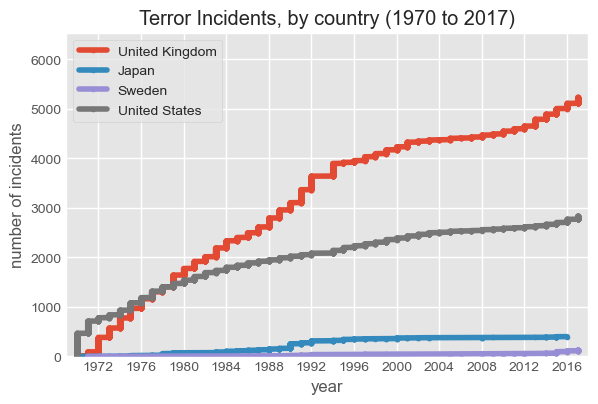

In [32]:
# Query 3b. Plot a time-series showing crime and stability in each country.
df = crime_df.sort_values(by=['Code','Event ID'])
df['Incidents'] = df.groupby(['Code']).cumcount()

num_attack_max = df['Incidents'].max()
num_years = df['Year'].nunique()
num_countries = df['Code'].nunique()
year_min = df['Year'].min()
year_max = df['Year'].max()

# Fill in missing years by padding using the previous year's values.
df['Incidents'] = df['Incidents'].interpolate()

options = {
    'xlabel': 'year',
    'ylabel': 'number of incidents',
    'title': f'Terror Incidents, by country ({year_min} to {year_max})',
    'xlim': (year_min - 1, year_max + 1),
    'ylim': (-2, num_attack_max * 1.25),
}

# Plot the crime information.
print(f'Plotting {options["title"]} for each {num_countries} countr(y/ies) across {num_years} year(s)...')
fig, ax = plt.subplots()

for key, grp in df.groupby(['Code']):
    ax.plot(grp['Year'], grp['Incidents'], '.-', label=df[df['Code'] == key]['Country'].unique()[0])

ax.set(**options)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(15))
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

ax.legend(loc='upper left', frameon=True)
ax.grid(True)

plt.show()


Plotting Casualties due to terrorism, by country (1970 to 2017) for each 4 countr(y/ies) across 47 year(s)...


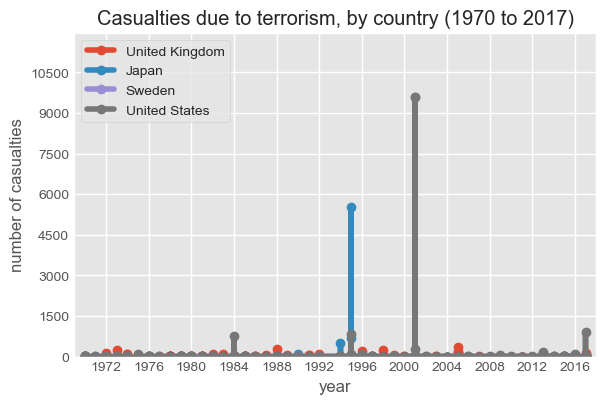

In [33]:
options = {
    'xlabel': 'year',
    'ylabel': 'number of casualties',
    'title': f'Casualties due to terrorism, by country ({year_min} to {year_max})',
    'xlim': (year_min - 1, year_max + 1),
    'ylim': (0, df['Casualties'].max() * 1.25),
}

# Plot the crime information.
print(f'Plotting {options["title"]} for each {num_countries} countr(y/ies) across {num_years} year(s)...')
fig, ax = plt.subplots()

for key, grp in df.groupby(['Code']):
    ax.plot(grp['Year'], grp['Casualties'], 'o-', label=df[df['Code'] == key]['Country'].unique()[0])

ax.set(**options)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(10))
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(15))
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

ax.legend(loc='upper left', frameon=True)
ax.grid(True)

plt.show()


Plotting Terror incidents vs. casualties, by country (1970 to 2017) for each 4 countr(y/ies) across 47 year(s)...


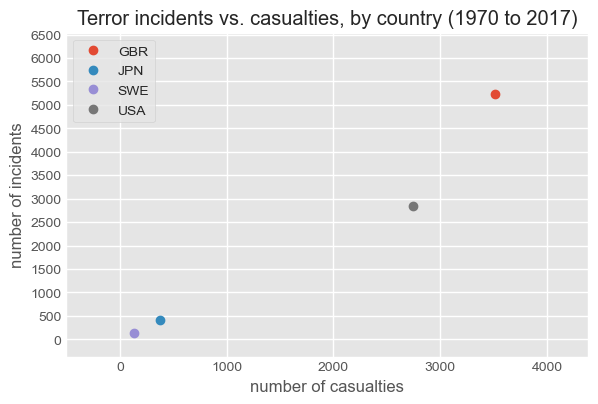

In [34]:
casualties_df = df.groupby(['Code']).count()['Casualties']
incidents_df = df.groupby(['Code']).max()['Incidents']

options = {
    'xlabel': 'number of casualties',
    'ylabel': 'number of incidents',
    'title': f'Terror incidents vs. casualties, by country ({year_min} to {year_max})',
    'xlim': (-500, casualties_df.max() * 1.25),
    'ylim': (incidents_df.min() - 500, incidents_df.max() * 1.25),
}

# Plot the crime information.
print(f'Plotting {options["title"]} for each {num_countries} countr(y/ies) across {num_years} year(s)...')
fig, ax = plt.subplots()

df = pd.concat([casualties_df, incidents_df], axis=1)
df = df.T

for code in df.columns:
    ax.plot(df[code]['Casualties'], df[code]['Incidents'], 'o', label=code)

ax.set(**options)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(15))
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

ax.legend(loc='upper left', frameon=True)
ax.grid(True)

plt.show()

<a id="query_ped" />

### Public Expenditure ###

In [35]:
mux = pd.MultiIndex.from_product([
    ped_df['Code'],
    range(ped_df['Year'].min(), 2018)
])

# Get missing years.
ped_df_intp = ped_df.set_index(['Code', 'Year'])
ped_df_intp = ped_df_intp.sort_index().reindex(mux).reset_index()
ped_df_intp.columns = ['Code', 'Year', 'Country', '%GDP']

# Map NaN values by code or interpolation.
ped_df_intp = ped_df_intp.drop(labels=['Country'], axis=1)
ped_df_intp['%GDP'] = ped_df_intp['%GDP'].interpolate()
display(ped_df_intp)

print('Actual statistics')
display(ped_df.groupby(['Code']).describe(include=np.object))
display(ped_df.groupby(['Code']).describe()['%GDP'])

display("***")
print('Interpolated statistics')
display(ped_df_intp.describe()['%GDP'])
display(ped_df_intp.groupby(['Code']).describe()['%GDP'])

,Code,Year,%GDP
0,GBR,1870,0.100000
1,GBR,1871,0.123256
2,GBR,1872,0.146512
3,GBR,1873,0.169767
4,GBR,1874,0.193023
...,...,...,...
2511,USA,2013,5.500000
2512,USA,2014,5.500000
2513,USA,2015,5.500000
2514,USA,2016,5.500000


Actual statistics


Country                            
       count unique             top freq
Code                                    
GBR        6      1  United Kingdom    6
JPN        6      1           Japan    6
SWE        3      1          Sweden    3
USA        2      1   United States    2

,count,mean,std,min,25%,50%,75%,max
Code,,,,,,,,
GBR,6.0,3.416667,2.288595,0.1,1.825,4.15,5.125,5.6
JPN,6.0,3.216667,1.919809,1.0,1.725,3.10,4.550,5.8
SWE,3.0,7.500000,2.100000,5.1,6.750,8.40,8.700,9.0
USA,2.0,4.750000,1.060660,4.0,4.375,4.75,5.125,5.5


'***'

Interpolated statistics


count    2516.000000
mean        3.782452
std         2.176227
min         0.100000
25%         1.683333
50%         4.143478
75%         5.290000
max         9.000000
Name: %GDP, dtype: float64

,count,mean,std,min,25%,50%,75%,max
Code,,,,,,,,
GBR,888.0,2.861486,1.872668,0.100000,0.890698,3.154167,4.365,5.600000
JPN,888.0,2.822121,1.530133,1.000000,1.474419,2.184000,4.270,5.800000
SWE,444.0,6.658622,1.317306,4.786957,5.329565,6.654783,7.830,9.000000
USA,296.0,5.112089,0.795118,4.000000,4.500000,5.002174,5.500,7.443478


Plotting Public expenditure on education, by country (1870 to 1993) for each 4 countr(y/ies) across 47 year(s)...


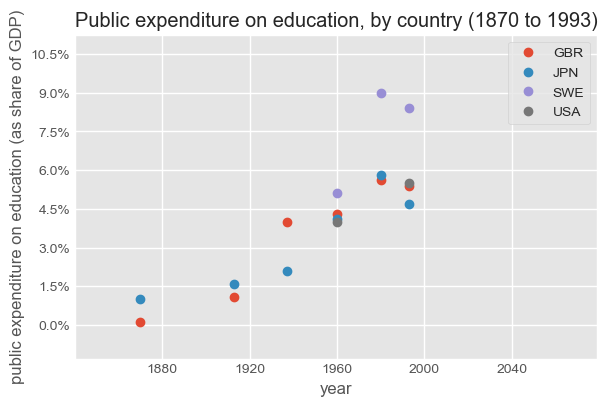

In [36]:
df = ped_df

year_min = df['Year'].min()
year_max = df['Year'].max()

options = {
    'xlabel': 'year',
    'ylabel': 'public expenditure on education (as share of GDP)',
    'title': f'Public expenditure on education, by country ({year_min} to {year_max})',
    'xlim': (df['Year'].quantile(0.25) * 0.95, df['Year'].quantile(0.75) * 1.05),
    'ylim': (0 - df['%GDP'].quantile(0.15), df['%GDP'].max() * 1.25),
}

# Plot the crime information.
print(f'Plotting {options["title"]} for each {num_countries} countr(y/ies) across {num_years} year(s)...')
fig, ax = plt.subplots()

for key, grp in df.groupby(['Code']):
    ax.plot(grp['Year'], grp['%GDP'], 'o', label=key)

ax.set(**options)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(df['Year'].nunique()))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

ax.legend(loc='upper right', frameon=True)
ax.grid(True)

plt.show()

Year                                                               \
      count    mean        std     min      25%     50%      75%     max   
Code                                                                       
GBR   888.0  1943.5  42.747021  1870.0  1906.75  1943.5  1980.25  2017.0   
JPN   888.0  1943.5  42.747021  1870.0  1906.75  1943.5  1980.25  2017.0   
SWE   444.0  1943.5  42.771138  1870.0  1906.75  1943.5  1980.25  2017.0   
USA   296.0  1943.5  42.795295  1870.0  1906.75  1943.5  1980.25  2017.0   

       %GDP                                                                     
      count      mean       std       min       25%       50%    75%       max  
Code                                                                            
GBR   888.0  2.861486  1.872668  0.100000  0.890698  3.154167  4.365  5.600000  
JPN   888.0  2.822121  1.530133  1.000000  1.474419  2.184000  4.270  5.800000  
SWE   444.0  6.658622  1.317306  4.786957  5.329565  6.654783  7.830  9.000000  
USA   296.0  5.112089  0.795118  4.000000  4.500000  5.002174  5.500  7.443478

Plotting Public expenditure on education, by country (1870 to 2017) for each 4 countr(y/ies) across 47 year(s)...


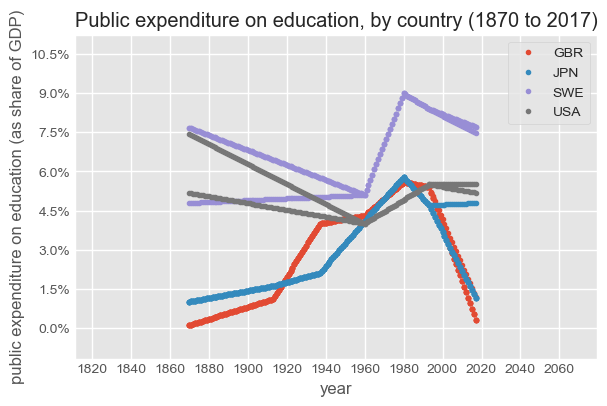

In [37]:
df = ped_df_intp

year_min = df['Year'].min()
year_max = df['Year'].max()

options = {
    'xlabel': 'year',
    'ylabel': 'public expenditure on education (as share of GDP)',
    'title': f'Public expenditure on education, by country ({year_min} to {year_max})',
    'xlim': (df['Year'].quantile(0.25) * 0.95, df['Year'].quantile(0.75) * 1.05),
    'ylim': (0 - df['%GDP'].quantile(0.15), df['%GDP'].max() * 1.25),
}

display(df.groupby(['Code']).describe())

# Plot the crime information.
print(f'Plotting {options["title"]} for each {num_countries} countr(y/ies) across {num_years} year(s)...')
fig, ax = plt.subplots()

for key, grp in df.groupby(['Code']):
    ax.plot(grp['Year'], grp['%GDP'], '.', label=key)

ax.set(**options)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(15))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

ax.legend(loc='upper right', frameon=True)
ax.grid(True)

plt.show()